# code to train the model based on the data in this folder

first import the necessary libraries


In [240]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib as mpl
import random
import PIL
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

dataset_dir = 'AAI_ES_A/'
class_names = ['left','straight','right']

## Collecting images

the images are stored in the folder `AAI_ES_A/`

In [241]:
# Load the data, it is in the dataset_dir and the class_names are the folders

def load_data(dataset_dir, class_names):
    images = []
    labels = []
    for i in range(len(class_names)):
        path = os.path.join(dataset_dir, class_names[i])
        class_label = class_names[i]
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            images.append(img_array)
            labels.append(class_label)
    return images, labels

images, labels = load_data(dataset_dir, class_names)

# convert the labels and images to numpy arrays
images = np.array(images)
labels = np.array(labels)

# randompze the arrays, the same way to keep the labels with the right data
s = np.arange(images.shape[0])
np.random.shuffle(s)
images = images[s]
labels = labels[s]

In [242]:
def convert_labels(labels):
    # convert the labels to a numerical value, -1 for left, 0 for straight, 1 for right
    for i in range(len(labels)):
        if labels[i] == 'left':
            labels[i] = -1
        elif labels[i] == 'straight':
            labels[i] = 0
        elif labels[i] == 'right':
            labels[i] = 1
        else: 
            print('error')
    # return the labels as a int
    return labels.astype(int)

labels = convert_labels(labels)

# print the amount for eace label
print("the amount for each label is: ", np.unique(labels, return_counts=True))

the amount for each label is:  (array([-1,  0,  1]), array([64, 86, 72]))


## Data augmentation


In [243]:
# we note that we can easily create more data by flipping the images and changing the labels to the opposite.

# create a new array with the flipped images
flipped_images = np.array([np.fliplr(image) for image in images])

# create a new array with the flipped labels
flipped_labels = np.array([-1*label for label in labels])

# add the flipped images and labels to the original images and labels
images = np.concatenate((images, flipped_images))
labels = np.concatenate((labels, flipped_labels))

## Pre processer

this preprocessor is made to make the image as small as posible while retainign enouth data to train and use the moddle.

In [244]:
def preprocess(image):
    assert image.shape == (224,224,3)
    # crop the top 80 pixels
    image = image[80:,:,:]
    # convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # resize to 64x64
    image = cv2.resize(image, (32, 32))
    # invert the image
    image = 255 - image
    # reduse the bit depth
    image = image // 16
    # Scale the images to the range of [0, 1]
    image = image / (255.0 / 16.0)
    return image

# preprocess the images
images = np.array([preprocess(image) for image in images])

# checking the dataset


In [245]:
# print the shape of the data and labels
print("the shape of the images is: ", images.shape)
print("the shape of the labels is: ", labels.shape)

# print the max and min pixel values
print("the max pixel value is: ", np.max(images))
print("the min pixel value is: ", np.min(images))

# print all the unique pixel values
print("the unique pixel values are: ", np.unique(images))

# print the labels
print("the labels are: ", np.unique(labels))

# print the amount for eace label
print("the amount of left turns is: ", np.sum(labels == -1))
print("the amount of straight turns is: ", np.sum(labels == 0))
print("the amount of right turns is: ", np.sum(labels == 1))

the shape of the images is:  (444, 32, 32)
the shape of the labels is:  (444,)
the max pixel value is:  0.8156862745098039
the min pixel value is:  0.12549019607843137
the unique pixel values are:  [0.1254902  0.18823529 0.25098039 0.31372549 0.37647059 0.43921569
 0.50196078 0.56470588 0.62745098 0.69019608 0.75294118 0.81568627]
the labels are:  [-1  0  1]
the amount of left turns is:  136
the amount of straight turns is:  172
the amount of right turns is:  136


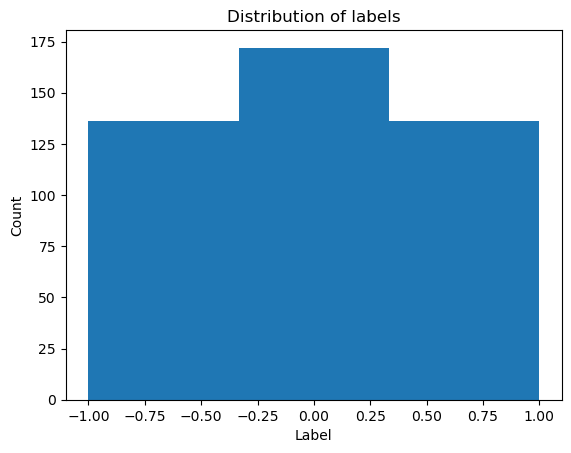

In [246]:
# plot the distripution of labels in a hystogram
plt.hist(labels, bins=3)
plt.title("Distribution of labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# split the data to train and test

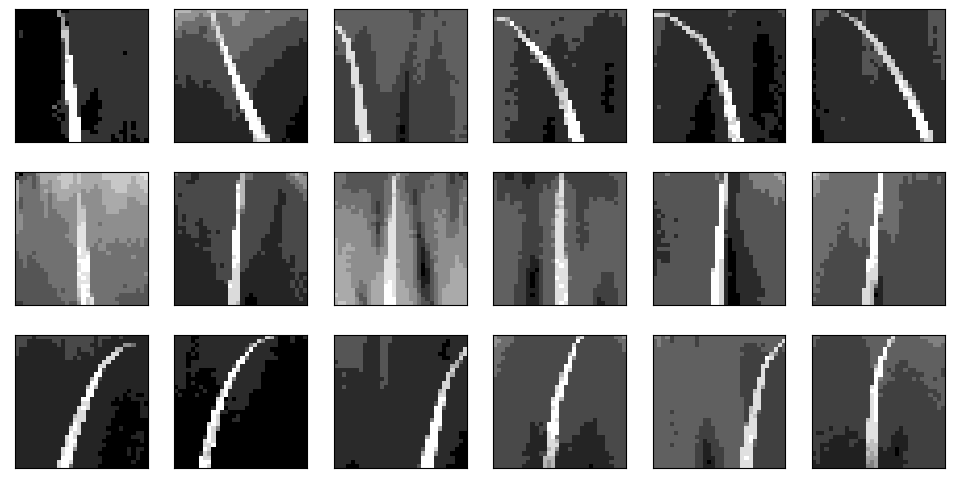

In [256]:
# we pik 6 random images fro each label, and draw them in a 3x6 grid

# split the images and labels into left, straight, and right
left_images = images[labels == -1]
straight_images = images[labels == 0]
right_images = images[labels == 1]

# pick 6 random images from each label
left_images = left_images[np.random.choice(len(left_images), 6, replace=False)]
straight_images = straight_images[np.random.choice(len(straight_images), 6, replace=False)]
right_images = right_images[np.random.choice(len(right_images), 6, replace=False)]

# plot the images
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
# remove the x and y ticks
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
for i in range(6):
    axes[0, i].imshow(left_images[i], cmap="gray")
    axes[1, i].imshow(straight_images[i], cmap="gray")
    axes[2, i].imshow(right_images[i], cmap="gray")
plt.show()

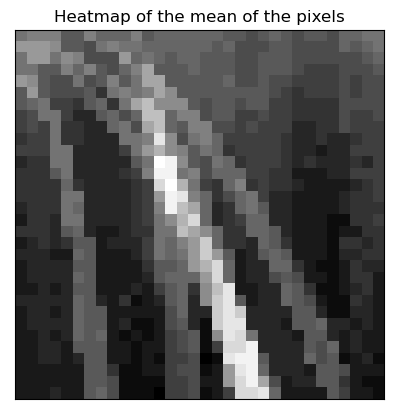

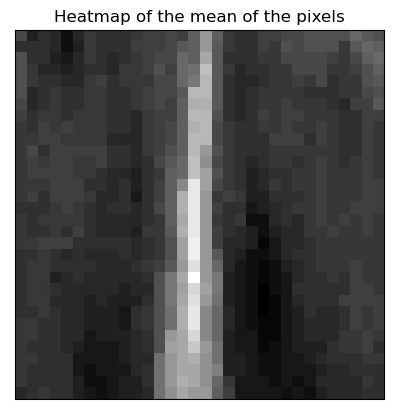

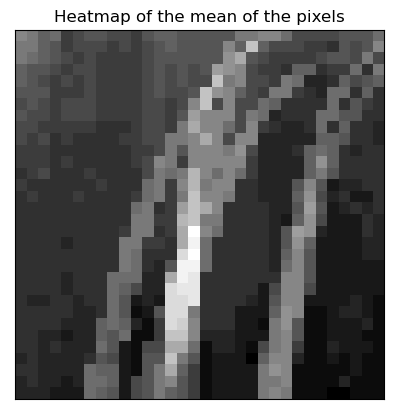

In [261]:
# plot a heatmap of all the pixels for each label

def plot_heatmap(groep):
    # create a 32x32 matrix with the mean of each pixel
    mean = np.mean(groep, axis=0)
    # plot the heatmap
    plt.imshow(mean, cmap="gray")
    # title the plot
    plt.title("Heatmap of the mean of the pixels")
    plt.xticks([])
    plt.yticks([])
    plt.show()

# plot the heatmaps
plot_heatmap(left_images)
plot_heatmap(straight_images)
plot_heatmap(right_images)


## split the data into training and validation sets

In [249]:
# first we make a test set, and then we split the remaining data into a validation and a training set
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.05, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# now we print the shape of the data
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (336, 32, 32)
X_val shape: (85, 32, 32)
X_test shape: (23, 32, 32)


## Making the model

we will use a simple CNN model to train the dataset

In [250]:
image_shape = X_train[0].shape

# make CNN the model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=128, kernel_size=7, strides=2, padding="same", activation="relu", input_shape=(image_shape[0], image_shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.AveragePooling2D(pool_size=3, strides=2, padding="same"))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation="linear"))

# compile the model
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

# print the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 16, 16, 128)       6400      
                                                                 
 dropout_25 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 64)          73792     
                                                                 
 dropout_26 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 average_pooling2d_5 (Averag  (None, 4, 4, 64)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_18 (Conv2D)          (None, 4, 4, 32)          18464     
                                                      

## Training the model

In [251]:
# Training the model, and after every epoch we update the history and plot the training and validation loss and accuracy, we also set the dropout rate to 0.5
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), verbose=1, shuffle=True)

Epoch 1/1000
11/11 [==============================] - 1s 46ms/step - loss: 2.4473 - mae: 1.2656 - val_loss: 0.5914 - val_mae: 0.5920
Epoch 2/1000
11/11 [==============================] - 0s 33ms/step - loss: 2.2318 - mae: 1.2225 - val_loss: 0.5817 - val_mae: 0.6221
Epoch 3/1000
11/11 [==============================] - 0s 32ms/step - loss: 2.2605 - mae: 1.2217 - val_loss: 0.5867 - val_mae: 0.5992
Epoch 4/1000
11/11 [==============================] - 0s 38ms/step - loss: 1.7934 - mae: 1.0817 - val_loss: 0.5916 - val_mae: 0.6073
Epoch 5/1000
11/11 [==============================] - 1s 48ms/step - loss: 1.7553 - mae: 1.0675 - val_loss: 0.5779 - val_mae: 0.6104
Epoch 6/1000
11/11 [==============================] - 0s 37ms/step - loss: 1.9884 - mae: 1.1214 - val_loss: 0.5744 - val_mae: 0.6198
Epoch 7/1000
11/11 [==============================] - 0s 41ms/step - loss: 1.5299 - mae: 0.9904 - val_loss: 0.6635 - val_mae: 0.6882
Epoch 8/1000
11/11 [==============================] - 0s 41ms/step - 

In [252]:
# Make a sound come from my mac when the training is done
os.system('say "The training is done"')

0

# check the training history

see if the model is overfitting.

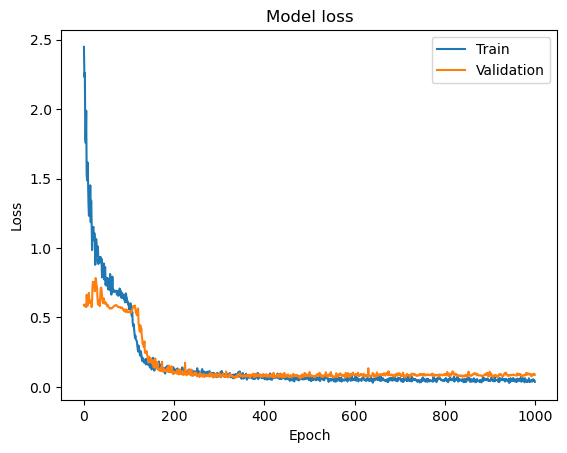

Final loss on validation set: 0.08771473169326782
Final mean absolute error on validation set: 0.11887416988611221


In [253]:
# plot the training and validation loss for each epoch
log = False
if log:
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
else:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# print the final loss and mean absolute error on the validation set
loss, mae = model.evaluate(X_val, y_val, verbose=0)
print("Final loss on validation set: {}".format(loss))
print("Final mean absolute error on validation set: {}".format(mae))

## check the training

1/1 [==============================] - 0s 39ms/step


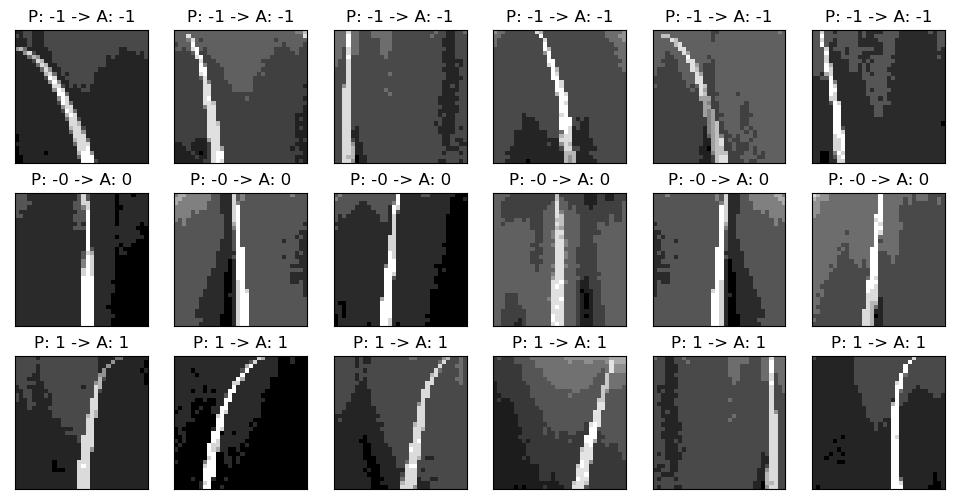

In [273]:
# now we take the test set and predict the labels, sort them by the labels and plot the images in groeps of there labels

# predict the labels
y_pred = model.predict(X_test)

# sort the images and labels by the predicted labels in 3 groupes
left_images = []
straight_images = []
right_images = []
left_pred = []
straight_pred = []
right_pred = []
left_class = []
straight_class = []
right_class = []
for i in range(len(y_pred)):
    if y_pred[i] < -0.5:
        left_images.append(X_test[i])
        left_pred.append(y_pred[i])
        left_class.append(y_test[i])
    elif y_pred[i] > 0.5:
        right_images.append(X_test[i])
        right_pred.append(y_pred[i])
        right_class.append(y_test[i])
    else:
        straight_images.append(X_test[i])
        straight_pred.append(y_pred[i])
        straight_class.append(y_test[i])


# plot the images
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
# remove the x and y ticks
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
for i in range(6):
    # the title for each plot is the predicted label and the actual label
    axes[0, i].set_title("P: {:.0f}".format(left_pred[i][0]) + " -> A: {:.0f}".format(left_class[i]))
    axes[1, i].set_title("P: {:.0f}".format(straight_pred[i][0]) + " -> A: {:.0f}".format(straight_class[i]))
    axes[2, i].set_title("P: {:.0f}".format(right_pred[i][0]) + " -> A: {:.0f}".format(right_class[i]))
    # plot the images
    axes[0, i].imshow(left_images[i], cmap="gray")
    axes[1, i].imshow(straight_images[i], cmap="gray")
    axes[2, i].imshow(right_images[i], cmap="gray")
plt.show()

In [274]:
# calculate the accuracy
correct = 0
for i in range(len(y_pred)):
    if y_pred[i] < -0.5 and y_test[i] == -1:
        correct += 1
    elif y_pred[i] > 0.5 and y_test[i] == 1:
        correct += 1
    elif y_pred[i] < 0.5 and y_pred[i] > -0.5 and y_test[i] == 0:
        correct += 1
print("Accuracy: {}".format(correct/len(y_pred)))


Accuracy: 0.9130434782608695


# save the model

In [275]:

output_filename = 'mini_proj_model_v02_01.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_types = [tf.float16]
tflite_fp16_model = converter.convert()

# This will save your model with the a file name tflite_model_fp16_file.tflite. You can uplaod this model file
# in your JetRacer to run it on the NVIDIA Jetson Nano.

with open(output_filename, 'wb') as f:
    f.write(tflite_fp16_model)

INFO:tensorflow:Assets written to: /var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/tmpsvotrxsb/assets


INFO:tensorflow:Assets written to: /var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/tmpsvotrxsb/assets
2023-01-10 19:14:15.300265: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-10 19:14:15.300283: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-01-10 19:14:15.301504: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/tmpsvotrxsb
2023-01-10 19:14:15.306685: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-01-10 19:14:15.306714: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/tmpsvotrxsb
2023-01-10 19:14:15.322598: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-01-10 19:14:15.327023: I tensorflow/cc/saved_model/load